In [1]:
# Time steps 11:22:10 -- 12:33:00

# Neural Network Classification with PyTorch

## Notebook Imports

In [2]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch import nn

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

## Data Loading

In [3]:
X, y = make_circles(1000, noise=0.03, random_state=42)
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
circles_df = pd.DataFrame(
    {
        'X1': X[:, 0],
        'X2': X[:, 1],
        'label': y
    }
)

circles_df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


## Data Visualization

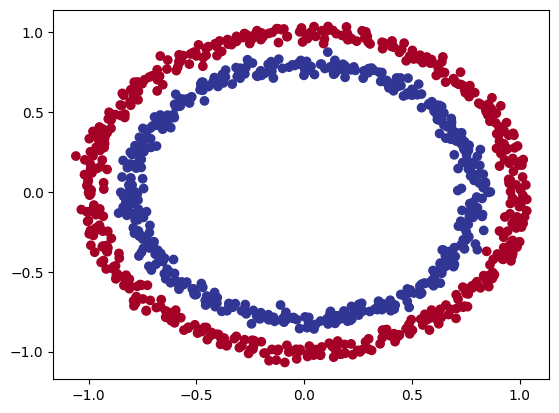

In [5]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## Turn the Data into Tensors

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building a Model

In [8]:
# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
# Contruct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
model_2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2775, -0.1345],
                      [-0.0885,  0.1421],
                      [-0.6232, -0.1193],
                      [ 0.7052,  0.4617],
                      [ 0.4422,  0.3301]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3400, -0.3814,  0.2898, -0.6490,  0.4608], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2945, -0.0721, -0.3300, -0.4407, -0.0858]], device='cuda:0')),
             ('1.bias', tensor([0.1200], device='cuda:0'))])

In [12]:
# Set up loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss() # has built-in sigmoid activation function
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.1)

In [13]:
# Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100 
    return acc

### Raw Logits -> Prediction Probabilities -> Prediction Labels

Model output are raw **logits** 
<br>
To convert them into **prediction probabilities**, we pass them to some kind of activation functions (sigmoid -> binary classification and softmax -> multiclass classification) 
<br>
Then to convert them into **prediction labels**, we round them or use `argmax()`

In [14]:
model_2.eval()

with torch.inference_mode():
    y_logits = model_2(X_test.to(device))[:5]    
y_logits

tensor([[ 0.0535],
        [-0.0352],
        [ 0.3131],
        [-0.0202],
        [ 0.3563]], device='cuda:0')

In [15]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5134],
        [0.4912],
        [0.5777],
        [0.4950],
        [0.5882]], device='cuda:0')

In [16]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_2(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 0., 1., 0., 1.], device='cuda:0')

In [17]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## Train a Model

1. Forward Pass
2. Calculate the Loss
3. Optimizer zero grad
4. Loss Backward (backpropagation)
5. Optimizer Step (gradient descent)

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    
    # Forward Pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # Calculate Loss / Accuracy
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # Optimizer Zero Grad
    optimizer.zero_grad()
    
    # Loss Backward
    loss.backward()
    
    # Optimizer Step
    optimizer.step()
    
    # Testing 
    model_2.eval()
    
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%')

Epoch: 0 | Loss: 0.70278 | Accuracy: 58.25% | Test Loss: 0.70305 | Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.69439 | Accuracy: 44.75% | Test Loss: 0.69612 | Test Accuracy: 49.00%
Epoch: 20 | Loss: 0.69314 | Accuracy: 49.50% | Test Loss: 0.69590 | Test Accuracy: 47.00%
Epoch: 30 | Loss: 0.69304 | Accuracy: 50.75% | Test Loss: 0.69501 | Test Accuracy: 48.00%
Epoch: 40 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69502 | Test Accuracy: 45.50%
Epoch: 50 | Loss: 0.69299 | Accuracy: 50.88% | Test Loss: 0.69469 | Test Accuracy: 46.00%
Epoch: 60 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69453 | Test Accuracy: 45.50%
Epoch: 70 | Loss: 0.69298 | Accuracy: 51.00% | Test Loss: 0.69473 | Test Accuracy: 46.00%
Epoch: 80 | Loss: 0.69298 | Accuracy: 51.75% | Test Loss: 0.69466 | Test Accuracy: 45.50%
Epoch: 90 | Loss: 0.69298 | Accuracy: 51.38% | Test Loss: 0.69473 | Test Accuracy: 45.50%


## Make Predictions and Evaluation

In [19]:
import requests
from pathlib import Path

In [20]:
if Path('helper_fuctions.py').is_file():
    print('File already exists!')
else:
    print('Downloading!')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

Downloading!


In [21]:
from helper_functions import plot_predictions, plot_decision_boundary

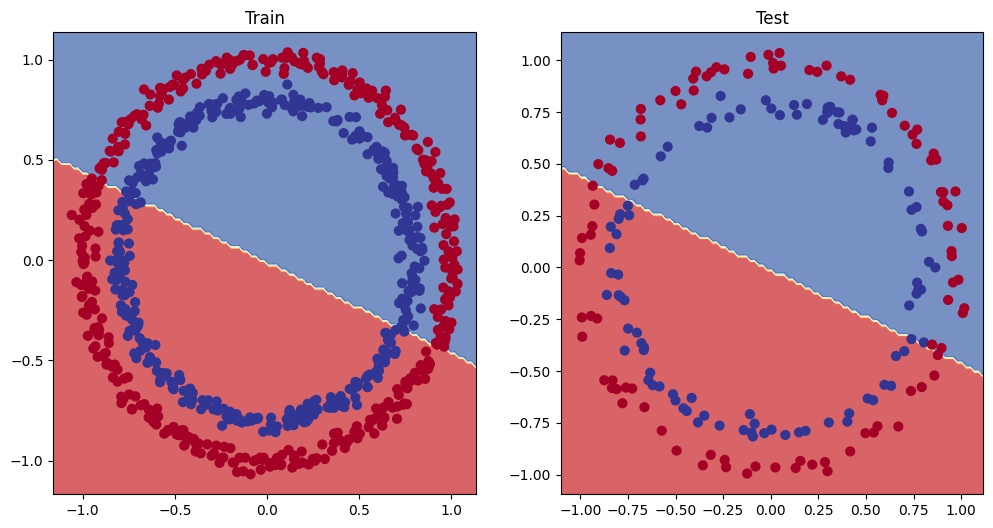

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)

## Improving a Model (from a model perspective)

How to improve a model:
* Add more layers
* Add more hidden units
* Fit for longer
* Change the activation functions
* Change the learning rate
* Change the loss function

In [23]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train, X_test, y_test  = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ## Training
    model_3.train()
    
    ### Forward Pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels
    
    ### Calculate the loss/accuracy
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    ### Optimizer zero grad
    optimizer.zero_grad()
    
    ### Loss Backward (backpropagation)
    loss.backward()
    
    ### Optimizer step 
    optimizer.step()
    
    ## Testing
    model_3.eval()
    
    with torch.inference_mode():
        ### Forward Pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        ### Calculate the Loss & Accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    ## Results
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} & Accuracy: {accuracy:.2f}% | Test Loss: {test_loss:.5f} & Test Accuracy: {test_accuracy:.2f}%')
        

Epoch: 0 | Loss: 0.69295 & Accuracy: 50.00% | Test Loss: 0.69319 & Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115 & Accuracy: 52.88% | Test Loss: 0.69102 & Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977 & Accuracy: 53.37% | Test Loss: 0.68940 & Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795 & Accuracy: 53.00% | Test Loss: 0.68723 & Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517 & Accuracy: 52.75% | Test Loss: 0.68411 & Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102 & Accuracy: 52.75% | Test Loss: 0.67941 & Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515 & Accuracy: 54.50% | Test Loss: 0.67285 & Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659 & Accuracy: 58.38% | Test Loss: 0.66322 & Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160 & Accuracy: 64.00% | Test Loss: 0.64757 & Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362 & Accuracy: 74.00% | Test Loss: 0.62145 & Test Accuracy: 79.00%


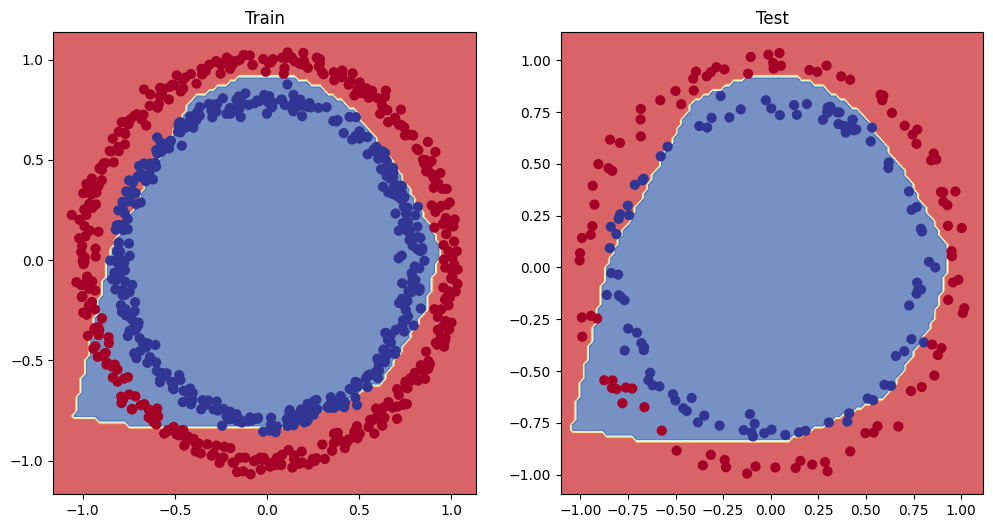

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)